# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.039059,True,4.356466
1,-0.170084,True,5.055127
2,0.903507,True,4.783136
3,-0.685721,False,-0.634004
4,0.605818,True,4.778427
...,...,...,...
995,-0.311753,False,0.649817
996,-0.052761,False,0.860718
997,-2.199326,False,-0.614103
998,-1.051772,False,-0.269741


<AxesSubplot: xlabel='v0'>

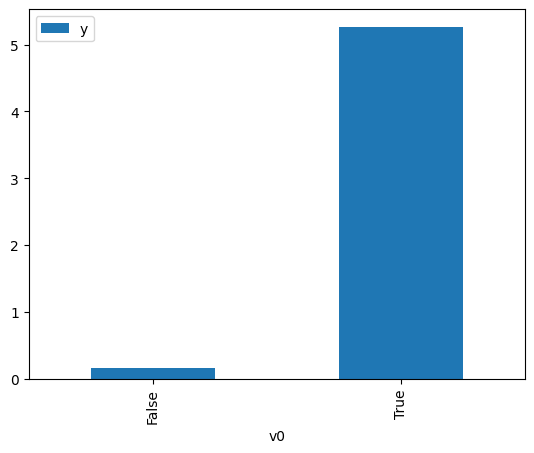

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

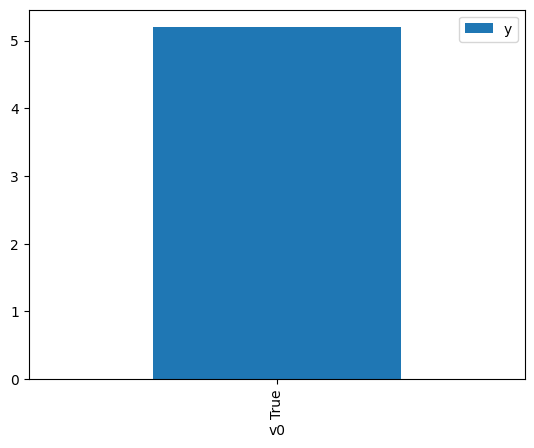

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.026302,False,-1.408663,0.487595,2.050884
1,0.225398,False,-0.165150,0.428151,2.335623
2,1.425669,False,0.705077,0.149969,6.668035
3,0.847629,False,-0.498528,0.261395,3.825622
4,1.316343,False,-0.494151,0.167537,5.968833
...,...,...,...,...,...
995,1.395080,False,0.345880,0.154726,6.463037
996,0.540685,False,-1.926557,0.338701,2.952453
997,0.674721,False,0.201872,0.303539,3.294468
998,1.532967,False,0.564494,0.134231,7.449856


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.558719,True,3.961232,0.341889,2.924926
1,0.029472,True,6.673840,0.513359,1.947953
2,-0.996655,True,3.406222,0.234643,4.261799
3,0.640986,True,6.218945,0.687805,1.453901
4,-0.420514,True,5.513620,0.380258,2.629791
...,...,...,...,...,...
995,-0.681743,True,3.637122,0.309375,3.232322
996,-0.079039,True,4.990468,0.480703,2.080286
997,0.102534,True,5.324461,0.535300,1.868111
998,-0.390272,True,7.003897,0.388877,2.571505


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8153.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):                        0.00
Time:                        11:28:44   Log-Likelihood:                         -1450.1
No. Observations:                1000   AIC:                                      2904.
Df Residuals:                     998   BIC:                                      2914.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5561      0.037     15.026      0.000       0.483       0.629
x2             4.9788      0.051     97.989      0.000       4.879       5.078
==============================================================================
Omnibus:                        2.109   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.348   Jarque-Bera (JB):                2.176
Skew:                           0.096   Prob(JB):                        0.337
Kurtosis:                       2.876   Cond. No.                         2.01
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""